In [54]:
import croissant as cro

from astropy.units import s as seconds
import healpy
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

In spherical coordinates, where $\theta$ is the polar angle, the power of a dipole antenna is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In [97]:
# 1 deg spacing, must be radians
theta = np.linspace(0, np.pi, num=181)
theta.shape = (1, -1, 1)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
# 1 MHz resolution frequency
freq = np.linspace(1, 50, num=50)
freq.shape = (-1, 1, 1)
# dipole beam
power = freq**2 * np.cos(theta)**2
power = np.repeat(power, phi.size, axis=-1)

In [99]:
beam = cro.beam.Beam(power, theta=theta, phi=phi, frequencies=freq)

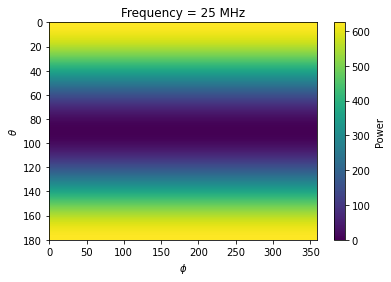

In [100]:
plot_freq = 25  # MHz
freq_ix = np.argmin(np.abs(beam.frequencies-plot_freq))
ex = [beam.phi.min(), beam.phi.max(), beam.theta.max(), beam.theta.min()]
ex_deg = [np.rad2deg(bd) for bd in ex]
plt.figure()
plt.imshow(beam.data[freq_ix], aspect="auto", extent=ex_deg)
plt.colorbar(label="Power")
plt.title(f"Frequency = {beam.frequencies[freq_ix]:.0f} MHz")
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
plt.show()

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model and extrpolate it by a power law to other frequencies. It has a built-in interface in the sky module of croissant.

In [101]:
sky = cro.sky.Sky.gsm(beam.frequencies, power_law=True, gen_freq=25, spectral_index=-2.5)

In [102]:
lmax = 16
loc = (37.87, 122.27, 0)
t_start = Time("2022-06-01 23:09:16")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end, moon=False, lmax=lmax, horizon=None
)

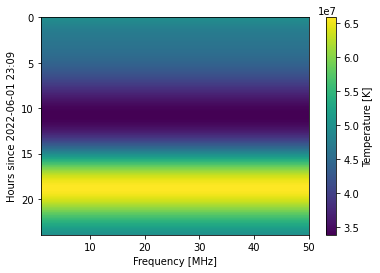

In [103]:
sim.run(dpss=False)
sim.plot(power=2.5)

In [104]:
# interpolate beam cubes
from scipy.interpolate import RectBivariateSpline

NPIX = 129
L = np.linspace(-1, 1, NPIX)  # cos(theta)
M = np.linspace(-1, 1, NPIX)  # sin(theta) sin(phi)
L.shape = (-1, 1)
M.shape = (1, -1)
L = L * np.ones_like(M)
M = M * np.ones_like(L)
LM = L**2 + M**2  # cos^2(t) + sin^2(t) sin^2(p) = 1 - sin^2(t) cos^2(p)
N = np.where(LM < 1, np.sqrt(1 - LM), 0)  # sin(theta) cos(phi)
th = np.arccos(L).flatten()
ph = np.arctan2(M, N).flatten() - np.pi
ph = np.where(ph < 0, 2*np.pi+ph, ph)

mask = np.where(LM < 1, 1, 0)
beams = np.array([RectBivariateSpline(beam.theta, beam.phi, d)(th, ph, grid=False) for d in np.sqrt(beam.data)])
#beams *= horizon_mask
print(beams.shape)
beams.shape = (-1, NPIX, NPIX)
beams *= mask  # set beam to 0 if LM >= 1 (which is outside the beam sphere anyway)
print(beams.shape)

/tmp/ipykernel_31828/2940377263.py:12: RuntimeWarning: invalid value encountered in sqrt
  N = np.where(LM < 1, np.sqrt(1 - LM), 0)  # sin(theta) cos(phi)


(50, 16641)
(50, 129, 129)


In [169]:
from hera_sim.visibilities.vis_cpu import vis_cpu as vis
import aipy

data = np.empty((sim.N_times, sim.frequencies.size), dtype=np.complex64)
antpos = np.array([[0., 0., 0.]])
hera_loc = [str(l) for l in loc[:2]]
aa = aipy.amp.AntennaArray(hera_loc, antpos)

jds = np.linspace(sim.t_start.to_value("jd"), t_end.to_value("jd"), sim.N_times)

nside = int(np.sqrt(sky.data.shape[-1] / 12))
hpb = aipy.healpix.HealpixBase(nside=nside)
crd_ga = np.array(hpb.px2crd(np.arange(hpb.npix())))
ga2eq = aipy.coord.convert_m('ga', 'eq')
crd_eq = ga2eq @ crd_ga

eq2tops = []
for jd in jds:
    aa.set_jultime(jd)
    eq2tops.append(aa.eq2top_m)
eq2tops = np.array(eq2tops)

for ch in range(sim.frequencies.size):
    print(ch)
    data[:,ch] = vis(antpos, sim.frequencies[ch] / 1e3, eq2tops, crd_eq, 2 * sky.data[ch], beams[ch:ch+1])[:,0,0]
    
wfall = data.real * (4 * np.pi / sky.data[0].size) / sim.beam.total_power

np.save("hera_sim.npy", wfall)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [173]:
np.allclose(healpy.Rotator(coord=["G", "C"]).mat, ga2eq)

True

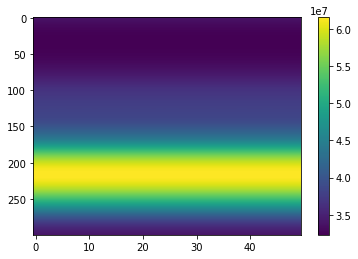

In [176]:
# done with sqrt(beam) and 2 * Sky.data

wfall = np.load("hera_sim.npy")
plt.figure()
plt.imshow(wfall * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

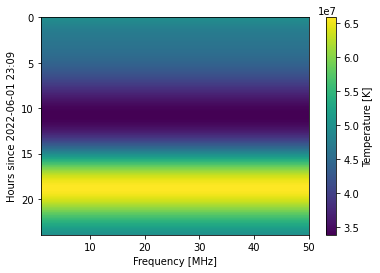

In [177]:
sim.plot(power=2.5)

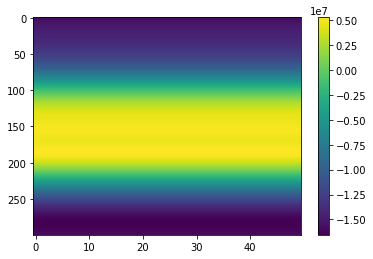

In [178]:
plt.figure()
plt.imshow((wfall - sim.waterfall) * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

In [196]:
tx, ty, tz = crd_top = np.dot(eq2tops[0], crd_eq)
above_horizon = tz > 0
tx = tx[above_horizon]
ty = ty[above_horizon]
nsrcs_up = len(tx)
print(nsrcs_up / len(crd_eq[0]))

0.5


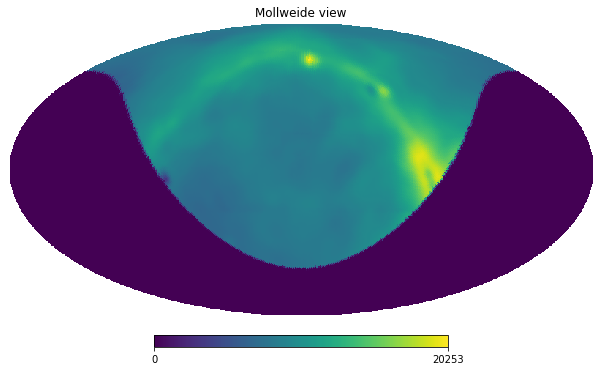

In [197]:
Isqrt = np.sqrt(sky.data)
rot = healpy.Rotator(coord=["G", "C"])
isqrt_eq = rot.rotate_map_pixel(Isqrt[0] * above_horizon.astype(int))
healpy.mollview(isqrt_eq)

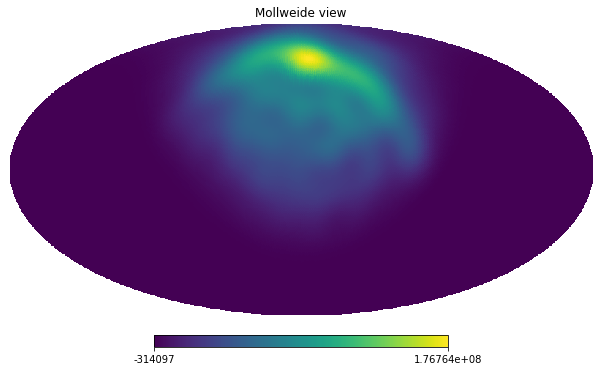

In [198]:
beam_m = cro.healpix.alm2map(sim.beam.alm, nside=64)
sky_m = sim.sky.hp_map()

healpy.mollview(beam_m[0] * sky_m[0])

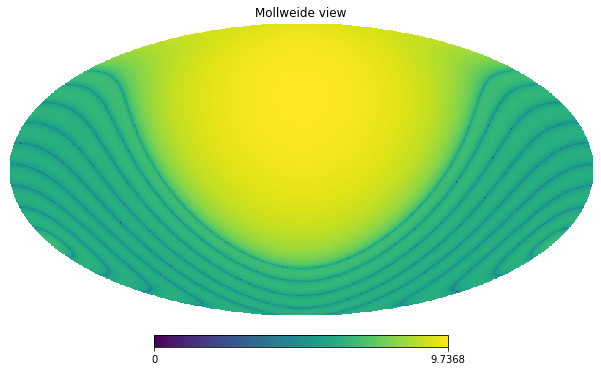

In [181]:
bp = np.abs(beam_m[0])
bp /= bp.min()
healpy.mollview(np.log10(bp))

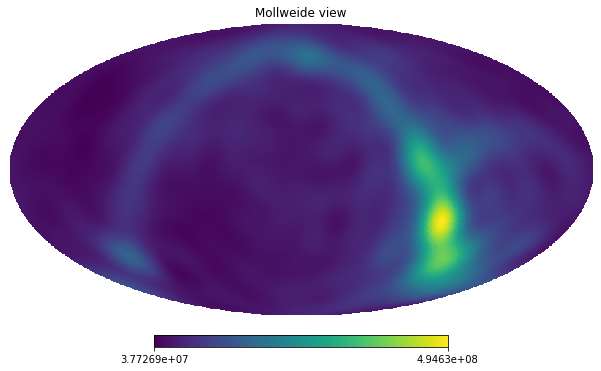

In [161]:
healpy.mollview(sky_m[0])

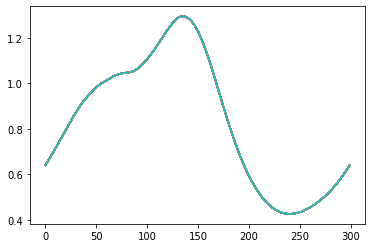

In [162]:
plt.figure()
for i in range(sim.frequencies.size):
    plt.plot((wfall[:, i] / sim.waterfall[:, i]))
plt.show()

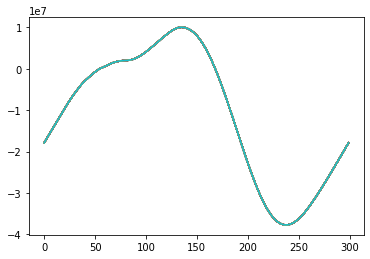

In [163]:
plt.figure()
for i in range(sim.frequencies.size):
    plt.plot((wfall[:, i] - sim.waterfall[:, i]) * sim.frequencies[i]**2.5)
plt.show()